# Buckling Analysis of Euler's Column

***

This notebook shows the calculation of the buckling load of Euler's column, that is to say a pin-ended column loaded in compression. Four methods are considered: Euler's analytical formula, MSC Nastran SOL 105's linear buckling analysis, MSC Nastran SOL 106's nonlinear buckling method and monitoring the definiteness of the tangent stiffness matrix during a nonlinear static analysis (using MSC Nastran SOL 106). The notebook is freely inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539) on the buckling analysis of a column with MSC Nastran.
* [Euler's buckling load](#euler)
* [Setup of the numerical model](#numerical-model)
* [SOL 105 - linear buckling analysis](#linear-buckling)
* [SOL 106 - nonlinear buckling method](#nonlinear-buckling)
* [SOL 106 - tangent stiffness matrix](#tangent-stiffness-matrix)
* [Conclusions](#conclusions)

## Euler's buckling load <a name="euler"></a>

***

Let's consider a column with diameter $d=20$ mm, length $l=420$ mm and Young's modulus $E=207$ GPa. The column is pinned at one end and has a roller support at the other end, where the load is applied in compression, as shown below.

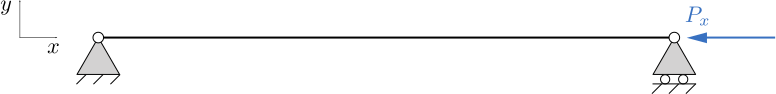

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '01_EulerColumn.svg'))  # sketch of Euler's column with boundary conditions and applied load


Euler's buckling load $P_{cr}$ is given by ([Megson, 2017, Chapter 8](http://www.aerostudents.com/courses/structural-analysis-and-design/Aircraft_Structures_for_Engineering_Students_6th_Edition.pdf)):
$$P_{cr}=\frac{\pi^2EI}{l^2},$$
where the area moment of inertia $I$ for a circular cross-sectional shape is calculated as:
$$I = \frac{\pi d^4}{64}.$$

Let's calculate $P_{cr}$ for our column.

In [2]:
import numpy as np  # package for working with arrays

d = 20.    # [mm]
l = 420.   # [mm]
E = 207e3  # [MPa]
I = np.pi*d**4/64  # [mm^4]
P_cr = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {P_cr:.0f} N')

Euler's buckling load: 90962 N


## Setup of the numerical model <a name="numerical-model"></a>

***

We want to run some linear and nonlinear analyses with MSC Nastran, so we need to create an appropriate numerical model and its corresponding input file. We'll use the [`pyNastran`](https://github.com/SteveDoyle2/pyNastran) package for this purpose.

We are going to define a base input object for our Nastran analyses. We'll complete this input object each time depending on the analysis we want to run. We'll use the function `create_base_bdf` from the module `column_utils`, where we can find some useful functions to work with Euler's column. `create_base_bdf` returns a `BDF` object representing a Nastran input file (.bdf) with nodes, beam elements, material properties, boundary conditions, unitary compression force applied to the column and some parameters for the output format of the results. The function takes as input:
- material properties including Young's modulus, Poisson's ratio and density;
- geometric properties of the column, namely length and diameter;
- number of beam elements used to discretize the column.

Let's define the missing material properties and let's create a base bdf input with 420 beam elements, so that each element is 1 mm long. Note that we'll be working with the _millimeter - newton - megapascal - ton_ system of units.


In [3]:
from resources import column_utils  # module with functions for Euler's column

# Define missing parameters for function create_base_bdf
nu = 0.3  # Poisson's ratio
rho = 7.8e-4  # material density [tons/mm^3]
no_elements = 420  # number of beam elements used to discretize the column

# Create base bdf input
base_bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)

subcase=0 already exists...skipping


Now let's get a summary of our `BDF` object with the `get_bdf_stats` method. The output of this method is a text with a list of the bulk data cards of our Nastran input, that we can print to the screen.

In [4]:
print(base_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[4]: 1
  FORCE:   1

bdf.spcadds[3]: 1
  SPCADD:  1

bdf.spcs[1]: 1
  SPC1:    1

bdf.spcs[2]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 421

bdf.elements: 0
  CBEAM    : 420

bdf.properties: 0
  PBEAML   : 1

bdf.materials: 0
  MAT1     : 1




Note that no solution sequence is defined in the function `create_base_bdf`. We'll need to define the solution sequence for each analysis that we want to run.

## SOL 105 - linear buckling analysis <a name="linear-buckling"></a>

***

The first numerical analysis that we are going to run is a linear buckling analysis, using solution sequence SOL 105. To complete our bdf input for such analysis, we execute the following steps:
- create a deep copy of the base `BDF` object (in order to preserve the original base `BDF` object and reuse it later);
- assign SOL 105 as solution sequence;
- create first subcase where we apply the compression load. To accomplish this we use the function `create_static_load_subcase` from the `pynastran_utils` module, which contains many useful functions to work with `pyNastran` objects;
- create second subcase where we solve the eigenvalue problem and consequently calculate the buckling load.

In [5]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

linear_buckling_bdf = base_bdf_input.__deepcopy__({})  # deep copy of base bdf object
linear_buckling_bdf.sol = 105  # solution sequence

# Create first subcase for the application of the compression load
load_application_subcase_id = 1  # define subcase id
force_set_id = list(linear_buckling_bdf.loads.keys())[0]  # retrieve id of the FORCE card representing the compression force
pynastran_utils.create_static_load_subcase(bdf_object=linear_buckling_bdf, subcase_id=load_application_subcase_id, load_set_id=force_set_id)  # create subcase

# Add EIGRL card to define a real eigenvalue analysis with the Lanczos method
eigrl_set_id = force_set_id + 1
linear_buckling_bdf.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue

# Create second subcase for the execution of the eigenvalue analysis
eigenvalue_calculation_subcase_id = 2  # define subcase id
linear_buckling_bdf.create_subcases(eigenvalue_calculation_subcase_id)  # create subcase
linear_buckling_bdf.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_set_id)  # add EIGRL card id to case control deck

The model for the linear buckling analysis is ready to run now! Let's define the name of the directory where we will run all the analyses of this notebook and the name of our input bdf file. Then we can call the function `run_analysis` from the `pynastran_utils` module, which we imported earlier. `run_analysis` creates the analysis directory if it doesn't exist alreardy, writes the input `BDF` object to a bdf file and runs the analysis with Nastran.

In [6]:
# Define name of analysis directory
analysis_directory_name = '01_Buckling_Analysis_of_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Define input name
base_input_name = 'euler_column'
linear_buckling_input_name = base_input_name + '_linear_buckling'

# Run analysis
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=linear_buckling_bdf, filename=linear_buckling_input_name, run_flag=False)

Now we can read Nastran's op2 output file with the `read_op2` function and we can look at the eigenvalue calculated in the second subcase. Since the eigenvalue represents the ratio between the buckling and the applied load and since our applied load is exactly 1 N, the eigenvalue corresponds to the buckling load. Let's print its value and the percentage difference with respect to the analytical result.

In [7]:
from pyNastran.op2.op2 import read_op2  # function to read Nastran's op2 file

# Read op2 file
op2_filename = os.path.join(analysis_directory_path, linear_buckling_input_name + '.op2')
linear_buckling_op2 = read_op2(op2_filename=op2_filename, load_geometry=True, debug=None)  # load results and geometry and do not print any debug or info message

# Find eigenvalue and print results to screen
sol_105_buckling_load = linear_buckling_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr  # retrieve eigenvalue from the OP2 object
print(f'SOL 105 buckling load: {sol_105_buckling_load:.0f} N')
print(f'Difference with respect to analytical buckling load: {(sol_105_buckling_load/P_cr-1)*100:.2f} %')

SOL 105 buckling load: 90578 N
Difference with respect to analytical buckling load: -0.42 %


We observe only a negligible difference with respect to Euler's buckling load, which can be most probably ascribable to the discretization error.

Let's visualize the buckling mode using the function `plot_buckling_mode` from the `column_utils` module.

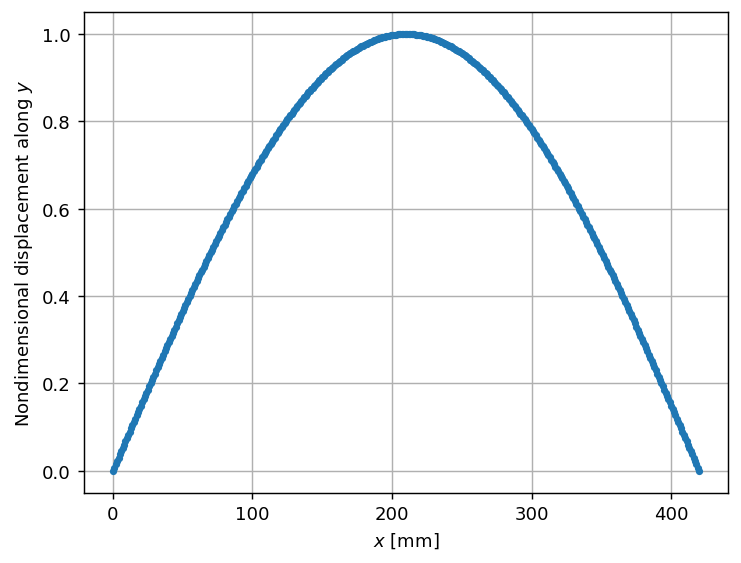

In [8]:
import matplotlib.pyplot as plt  # plotting package

plt.rcParams['figure.dpi'] = 130  # set default dpi of figures
column_utils.plot_buckling_mode(op2_object=linear_buckling_op2)

## SOL 106 - nonlinear buckling method <a name="nonlinear-buckling"></a>

***

Our next numerical analysis is a nonlinear analysis with solution sequence SOL 106, where we want to use the so-called nonlinear buckling method. This method was described by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016) and is based on the hypothesis that the components of the tangent stiffness matrix vary linearly in a small range close to the last two converged solutions. If a critical point exists sufficiently close to the last converged solution, then the tangent stiffness matrix at such point can be expressed as:

$$\mathbf{K_{cr}}=\mathbf{K_n}+\lambda\mathbf{\Delta K},$$

where $\mathbf{\Delta K}=\mathbf{K_n}-\mathbf{K_{n-1}}$ is the differential stiffness matrix based on the last two converged solutions $n$ and $n-1$ and $\lambda$ is a proportionality factor.

Since the tangent stiffness matrix is singular at the critical point, we can formulate the following eigenvalue problem:

$$\left(\mathbf{K_n}+\lambda\mathbf{\Delta K}\right)\mathbf{\phi}=\mathbf{0},$$

where $\lambda$ and $\mathbf{\phi}$ respectively represent the eigenvalues and the eigenvectors related to the critical displacements $\mathbf{U_{cr}}$:

$$\mathbf{U_{cr}}=\mathbf{U_n}+\lambda\mathbf{\Delta U},$$

with $\mathbf{\Delta U}=\mathbf{U_n}-\mathbf{U_{n-1}}$. Nastran calculates the vector of critical buckling loads $\mathbf{P_{cr}}$ as:

$$\mathbf{P_{cr}}=\mathbf{P_n}+\alpha\mathbf{\Delta P},$$

where $\mathbf{P_n}$ is the vector of the applied loads, $\alpha$ is the critical buckling factor and $\mathbf{\Delta P}$ is the last load increment vector applied in the nonlinear analysis. $\alpha$ and $\lambda$ are related by the following expression:

$$\alpha=\frac{\lambda\mathbf{\Delta U}^\intercal\left(\mathbf{K_n}+\frac{1}{2}\lambda\mathbf{\Delta K}\right)\mathbf{\Delta U}}{\mathbf{\Delta U}^\intercal\mathbf{\Delta P}}.$$

As suggested by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016), we need to monitor the value of $\alpha$ because when it is greater than unity the predicted buckling point is not close to the last solution point and as a consequence the prediction should not be considered reliable.

To complete our bdf input for this analysis, we execute the following steps:
- create a deep copy of the base `BDF` object;
- assign SOL 106 as solution sequence;
- create first subcase where we apply a compression force equal to the buckling load predicted by SOL 105;
- define the parameters for the eigenvalue computation, this time carried out in the same subcase.

In [9]:
nonlinear_buckling_bdf = base_bdf_input.__deepcopy__({})  # deep copy of BDF object
nonlinear_buckling_bdf.sol = 106  # solution sequence

# Creat first subcase
nonlinear_buckling_bdf.loads[force_set_id][0].mag = sol_105_buckling_load  # set force magnitude equal to SOL 105 buckling load
first_subcase_id = 1  # define subcase id
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_buckling_bdf, subcase_id=first_subcase_id, load_set_id=force_set_id)  # create subcase

# Add EIGB card to define an eigenvalue analysis with inverse power method
eigb_set_id = force_set_id + 1
nonlinear_buckling_bdf.add_eigb(sid=eigb_set_id, method='INV', L1=-1., L2=1e10, nep=1, ndp='', ndn='', norm='', G='', C='')  # define buckling analysis with inverse power method to find one positive and one negative root
nonlinear_buckling_bdf.case_control_deck.subcases[first_subcase_id].add_integer_type('METHOD', eigb_set_id)  # add EIGB card id to case control deck

In SOL 106 we need to specify some additional parameters and cards for the nonlinear analysis.

First we define two PARAM cards to enable large displacement effects and to flag the use of the nonlinear buckling method.

In [10]:
nonlinear_buckling_bdf.add_param('LGDISP', [1])  # assume all nonlinear structural element types that have a large displacement capability to have large displacement effects
nonlinear_buckling_bdf.add_param('BUCKLE', [2])  # request nonlinear buckling method in a SOL 106 cold start run

PARAM     BUCKLE       2


Successively we define the arc-length method as our iteration method. We first add the NLPARM card to set the general parameters of the nonlinear iteration strategy. We use the following settings:
* `ninc=100` to set the initial load increment $\Delta\mu^1 = 1/NINC$ to $1\%$ of the total applied load;
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration;
* `max_iter=25` to set the maximum number of iterations for each load increment;
* `conv='PUV'` to select convergence criteria based on load equilibrium and displacement errors with vector component method (convergence checking is performed on the maximum vector component of all components in the model);
* `int_out='YES'` to process the output for every converged load increment;
* `eps_p=1e-3` and `eps_u=1e-3` to set the error tolerance for the load and displacement criteria, respectively;
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment.

In [11]:
nlparm_id = 1  # id of the NLPARM and NLPCI cards
nonlinear_buckling_bdf.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)

NLPARM         1     100            ITER       1             PUV     YES
            .001    .001
              10

Then we add a NLPCI card to define the parameters of the arc-length method:
* `Type='CRIS'` to set Crisfield constraint type;
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, where $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$ and $\frac{\Delta l_{new}}{\Delta l_{old}}$ is the adjument ratio of the arc-length;
* `desiter=5` to set the desired number of iterations for convergence, which is used to calculate the arc-length for the next increment $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$, where $I_{max}$ represents the number of iterations required for convergence in the previous load increment;
* `mxinc=1000` to set the maximum number of controlled increment steps allowed within a subcase.

In [12]:
nonlinear_buckling_bdf.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=1000)  # same identification number of NLPARM card is used becasue NLPCI card must be associated to a NLPARM card

NLPCI          1    CRIS     .01     1.1      0.               5    1000

Finally, we need to select the NLPARM card that we have just defined in the case control deck.

In [13]:
nonlinear_buckling_bdf.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

The parameters employed here are inspired by the [Shallow Cylindrical Shell Snap-through example](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38.xhtml#TOC_Shallow_Cylindrical) from the MSC Nastran *Demontration Problems Guide - Implicit Nonlinear*.

Now the Nastran input is ready to be run, so let's define a name for our bdf file and call the `run_analysis` function.

In [14]:
nonlinear_buckling_input_name = base_input_name + '_nonlinear_buckling_method'  # input file name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, filename=nonlinear_buckling_input_name, run_flag=False)  # run analysis

We read the nonlinear buckling load $P_{cr}$ and the critical buckling factor $\alpha$ using the `read_nonlinear_buckling_load_from_f06` function from the `pynastran_utils` module. We print the results and plot the buckling shape.

SOL 106 buckling load: 90578 N
Critical buckling factor ALPHA = -4.3e-06


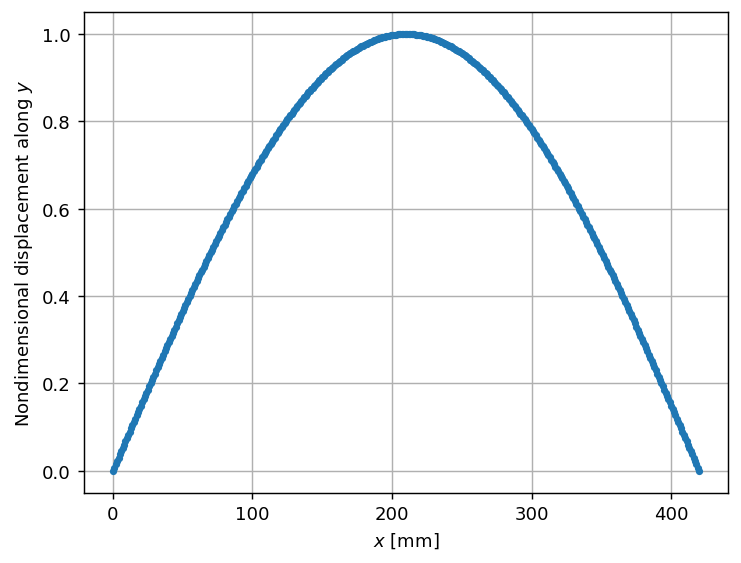

In [15]:
f06_filepath = os.path.join(analysis_directory_path, nonlinear_buckling_input_name + '.f06')  # path to .f06 file
op2_filepath = os.path.join(analysis_directory_path, nonlinear_buckling_input_name + '.op2')  # path to .op2 file
nonlinear_buckling_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)  # load results and geometry and do not print any debug or info message
buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=f06_filepath, op2_object=nonlinear_buckling_op2)  # return list of nonlinear buckling loads and list of critical buckling factors
sol_106_buckling_load = buckling_loads[0]  # store first and only one buckling load
print(f'SOL 106 buckling load: {sol_106_buckling_load:.0f} N\nCritical buckling factor ALPHA = {critical_buckling_factors[0]:.1e}')  # print results
column_utils.plot_buckling_mode(op2_object=nonlinear_buckling_op2)  # plot buckling mode

We observe that there is no noticeable difference between the linear and the nonlinear buckling load and shape. In fact, given the symmetry of the problem and the absence of material nonlinearities, there is no reason why the buckling load and shape should differ between the two analyses. Furthermore, the absolute value of $\alpha$ is well below unity, which suggests that the points used to calculate the differential stiffness matrix are close to the critical point.

## SOL 106 - tangent stiffness matrix <a name="tangent-stiffness-matrix"></a>

***

The stability of an equilibrium point of a structure is assessed by looking at the Hessian of the potential energy $\Pi$, that corresponds to the tangent stiffness matrix $\mathbf{K_T}$ at that point:

$$\mathbf{H}_\Pi=\frac{\partial^2\Pi}{\partial\mathbf{q}^2}=\mathbf{K_{T},$$

where $\mathbf{q}$ is the vector of the generalized coordinates. For stable points the tangent stiffness matrix is positive definite, while at critical points the matrix becomes singular. This means that at least one eigenvalue must be zero. As a consequence, we can assess the buckling load of Euler's column by looking at the load where the lowest eigenvalue of the tangent stiffness matrix becomes null.

For this analysis we use the same input used for the nonlinear buckling method. We only need to add a command to calculate the lowest eigenvalue of the tangent stiffness matrix at every load increment and print it in the f06 file. For this purpose, we include an appropriate DMAP sequence in the executive control statements.

In [16]:
nonlinear_buckling_bdf.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv_nobuckle.dmap') + '\'']  # include DMAP sequence

It should be noted that theoretically in this case we don't need the bulk data entry `PARAM,BUCKLE,2`, as we are not using SOL 106's nonlinear buckling method, like we did in our previous analysis. However, without such entry Nastran does not update the tangent stiffness matrix after the last load increment. For this reason we keep the parameter `PARAM,BUCKLE,2` making sure that the DMAP sequence skips the buckling calculation.

Let's apply a compression load equal to the buckling load found in the previous analyis rounded up to the next thousand, as we want to observe the lowest eigenvalue of the tangent stiffness matrix becoming negative.

In [17]:
nonlinear_buckling_bdf.loads[force_set_id][0].mag = np.ceil(sol_106_buckling_load/1e3)*1e3  # change magnitude of force card to buckling load found by SOL 106 nonlinear buckling method rounded up to next thousand

Let's define the input file name andrun the analysis.

In [18]:
tangent_stiffness_matrix_input_name = base_input_name + '_tangent_stiffness_matrix'  # name of input file
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, filename=tangent_stiffness_matrix_input_name, run_flag=False)

Now we want to plot the lowest eigenvalue of the tangent stiffness matrix for every load increment versus the load history of the nonlinear analysis. We start by finding the load history of the nonlinear analysis using the function `read_load_displacement_history_from_op2` from the `pynastran_utils` module.

In [19]:
op2_filepath = os.path.join(analysis_directory_path, tangent_stiffness_matrix_input_name + '.op2')
tangent_stiffness_matrix_op2 = read_op2(op2_filename=op2_filepath, debug=None) # read results from op2 file and do not print any debug or info message
_, load_history, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=tangent_stiffness_matrix_op2)
applied_load_history = -[*load_history.values()][0][:,0]  # retrieve applied load history

Successively, we find the lowest eigenvalues in the f06 file using the function `read_kllrh_lowest_eigenvalues_from_f06` from the same module.

In [20]:
f06_filepath = os.path.join(analysis_directory_path, tangent_stiffness_matrix_input_name + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read the lowest eigenvalue of KLLRH matrices from f06 file

Finally, we plot the results nondimensionalizing the applied load by the critical buckling load found with SOL 106's nonlinear buckling method.

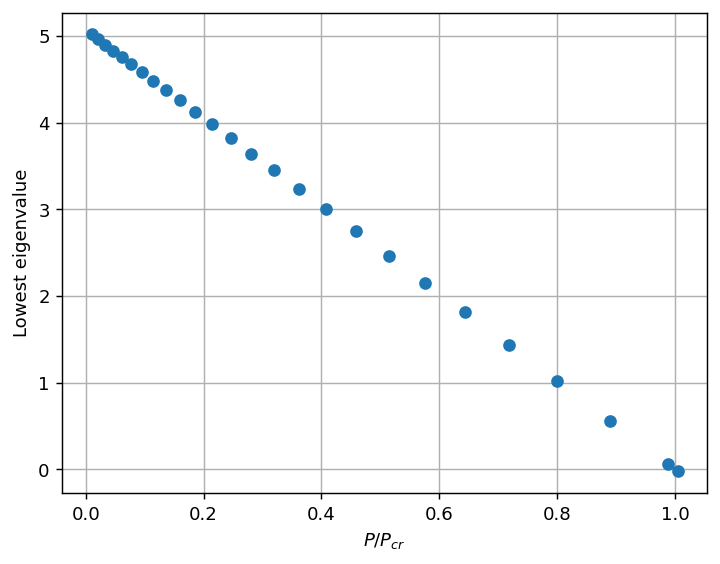

In [21]:
fig, ax = plt.subplots()
ax.plot(applied_load_history/sol_106_buckling_load, lowest_eigenvalues, 'o')
plt.xlabel('$P/P_{cr}$')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()

We can see that the lowest eigenvalue of the tangent stiffness matrix decreases linearly with the applied load and that after the last converged iteration is slightly negative. Let's print its value to the screen.

In [22]:
print(f'Value of lowest eigenvalue after final load increment: {lowest_eigenvalues[-1]:.3f}')

Value of lowest eigenvalue after final load increment: -0.024


The eigenvalue is indeed negative and this means that the structural equilibrium at the last converged iteration is unstable. We can interpolate between the last two points to find the load where the lowest eigenvalue is zero, which corresponds to the critical buckling load.

In [23]:
# Fit line between last two points
fit = np.polyfit(lowest_eigenvalues[-2:], applied_load_history[-2:], 1)
line = np.poly1d(fit)

# Find load where eigenvalue is zero and print its value
tangent_stiffness_matrix_buckling_load = line(0.)
print(f'Load where tangent stiffness matrix becomes singular: {tangent_stiffness_matrix_buckling_load:.0f} N')

Load where tangent stiffness matrix becomes singular: 90578 N


As we can see, there is no evident difference with the other numerical results.

## Conclusions <a name="conclusions"></a>

***

In this notebook we analyzed the buckling load of Euler's column with different methods. First we used Euler's analytical formula, and for the considered geometry and material we obtained a buckling load of 90962 N. Successively we used MSC Nastran to compute the buckling load of the column with different types of numerical analysis.

We discretized the column with beam elements and we carried out a linear buckling analysis with SOL 105. This resulted in a buckling load of 90578 N, that is 0.42% lower than the analytical result. Then we switched to Nastran's nonlinear solution sequence, SOL 106. We first used the nonlinear buckling method available with the solution sequence, resulting in the same buckling load obtained with SOL 105. Then we used SOL 106 to find the load where the lowest eigenvalue of the tangent stiffness matrix becomes null, that is to say where the matrix becomes singular. The same value of buckling load found was obtained also in this case. As a consequence, the different buckling calculations carried out with Nastran appear to be consistent. This is in line with expectations because no nonlinear behavior is supposed to be observed up to the buckling point considering the symmetry of the problem.

We will continue our investigation on the Euler's column studying its supercritical pitchfork bifurcation in our [next notebook](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb).